In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from keras.layers.core import Activation, Dropout
from keras.callbacks import EarlyStopping
import time
from matplotlib import pyplot
import numpy
import random
from keras_self_attention import SeqSelfAttention
from tcn import TCN
import tensorflow as tf
import time
start_time = time.time()

# IMF2

<Figure size 2000x800 with 0 Axes>

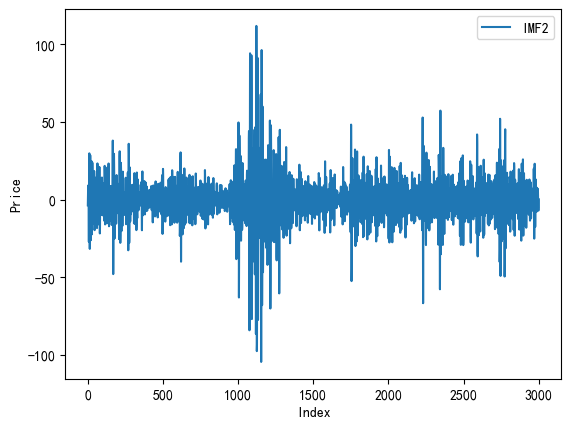

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn (TCN)                   (None, 32)                39200     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

Epoch 53/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 0.0011 - val_mae: 0.0241
Epoch 54/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0011 - val_mae: 0.0243
Epoch 55/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 9.8907e-04 - val_mae: 0.0233
Epoch 56/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 57/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0015 - mae: 0.0273 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 58/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 9.7223e-04 - val_mae: 0.0231
Epoch 59/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 60/200
68/68 [==============================] - 1s 9ms/step

Epoch 113/200
68/68 [==============================] - 1s 9ms/step - loss: 9.4859e-04 - mae: 0.0214 - val_loss: 9.1912e-04 - val_mae: 0.0237
Epoch 114/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0224 - val_loss: 7.2826e-04 - val_mae: 0.0206
Epoch 115/200
68/68 [==============================] - 1s 9ms/step - loss: 9.8231e-04 - mae: 0.0211 - val_loss: 7.5811e-04 - val_mae: 0.0208
Epoch 116/200
68/68 [==============================] - 1s 10ms/step - loss: 9.2070e-04 - mae: 0.0202 - val_loss: 6.7410e-04 - val_mae: 0.0196
Epoch 117/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 9.0044e-04 - val_mae: 0.0233
Epoch 118/200
68/68 [==============================] - 1s 10ms/step - loss: 9.9917e-04 - mae: 0.0216 - val_loss: 8.4064e-04 - val_mae: 0.0217
Epoch 119/200
68/68 [==============================] - 1s 10ms/step - loss: 9.8320e-04 - mae: 0.0209 - val_loss: 7.2631e-04 - val_mae: 0.0205
Epoch 120/200
68/6

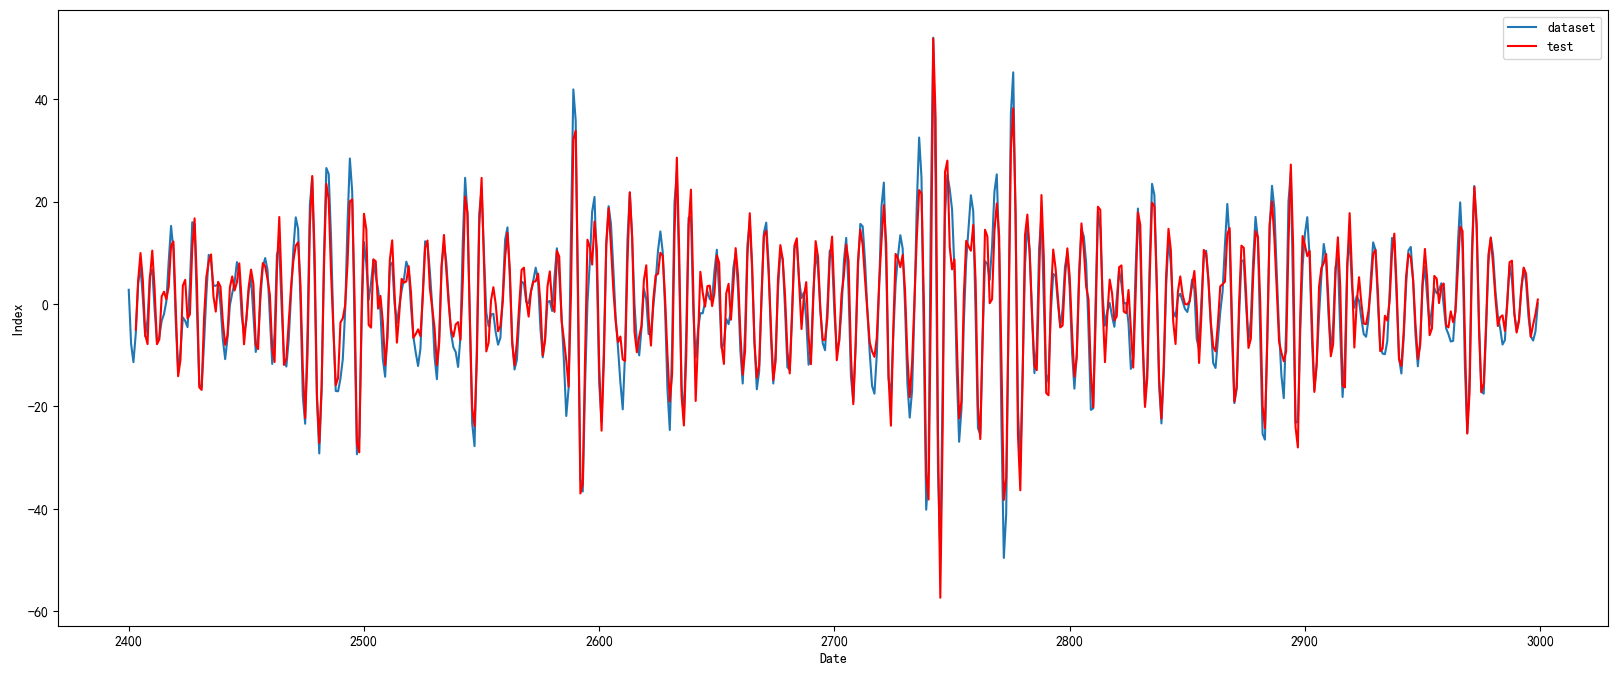

In [2]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF2_pre= pd.DataFrame(testPredict)
IMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF3

<Figure size 2000x800 with 0 Axes>

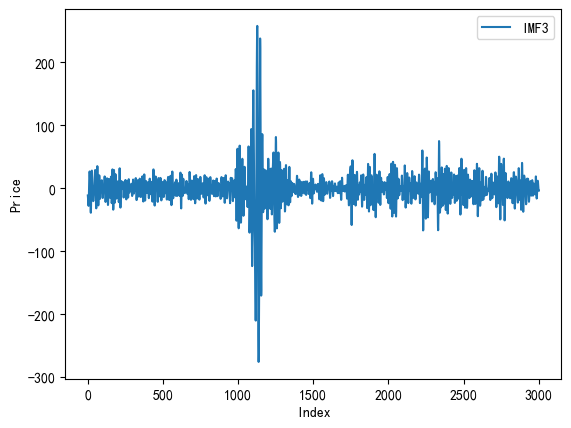

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

Epoch 51/100
68/68 [==============================] - 1s 9ms/step - loss: 4.5983e-04 - mae: 0.0148 - val_loss: 1.9305e-04 - val_mae: 0.0110
Epoch 52/100
68/68 [==============================] - 1s 10ms/step - loss: 4.1807e-04 - mae: 0.0131 - val_loss: 2.0271e-04 - val_mae: 0.0111
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 4.3926e-04 - mae: 0.0136 - val_loss: 1.3685e-04 - val_mae: 0.0089
Epoch 54/100
68/68 [==============================] - 1s 10ms/step - loss: 6.4809e-04 - mae: 0.0145 - val_loss: 2.3875e-04 - val_mae: 0.0126
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 4.6553e-04 - mae: 0.0135 - val_loss: 1.7430e-04 - val_mae: 0.0105
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 4.9340e-04 - mae: 0.0134 - val_loss: 2.2637e-04 - val_mae: 0.0127
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 4.2244e-04 - mae: 0.0134 - val_loss: 2.1755e-04 - val_mae: 0.0119
Epoch 58/100
68/6

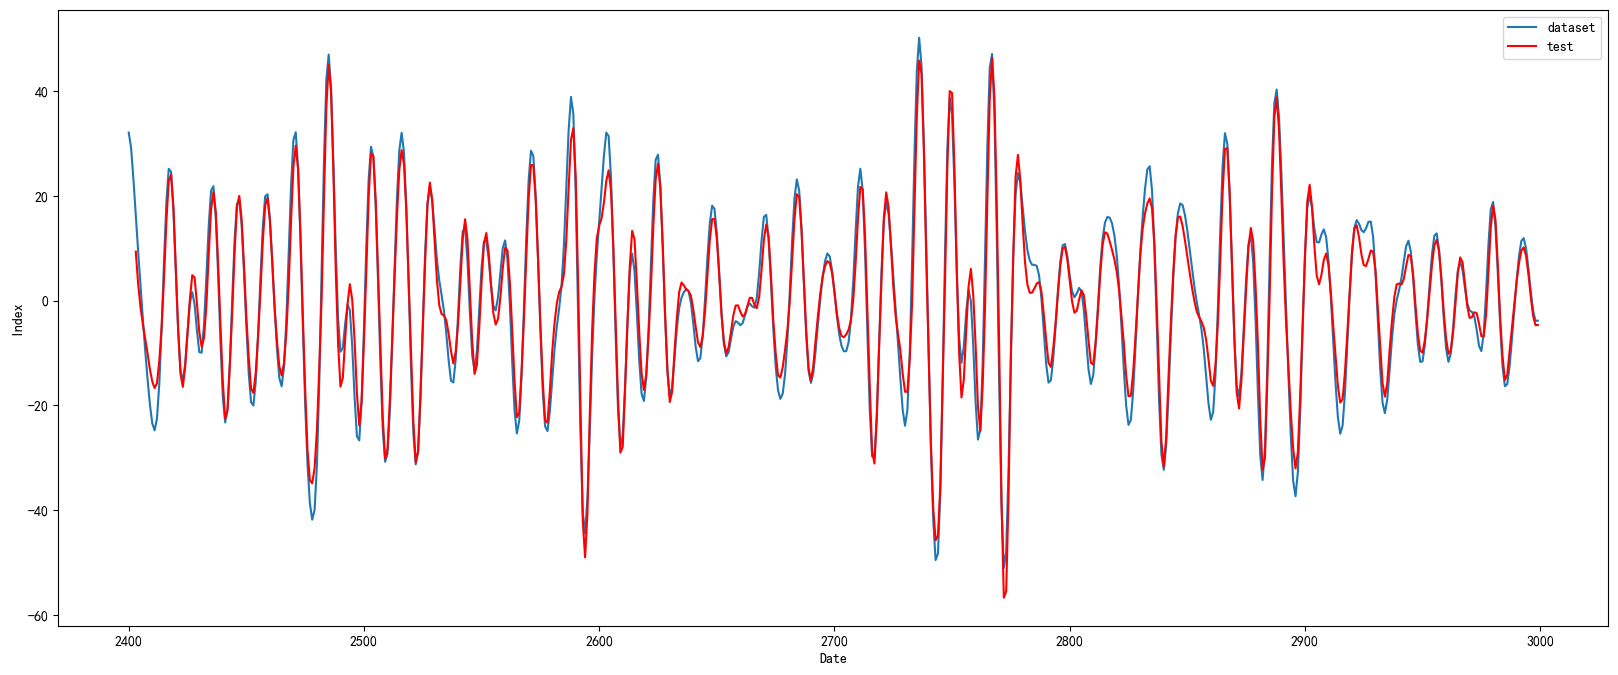

In [3]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF3_pre= pd.DataFrame(testPredict)
IMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF4

<Figure size 2000x800 with 0 Axes>

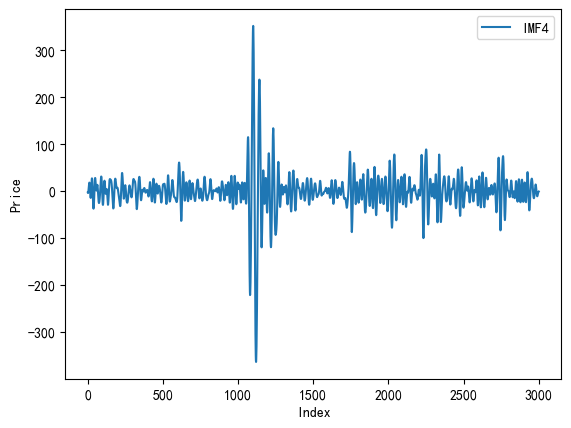

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_2 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 4.4167e-04 - mae: 0.0135 - val_loss: 2.8921e-04 - val_mae: 0.0151
Epoch 51/200
68/68 [==============================] - 1s 10ms/step - loss: 5.3060e-04 - mae: 0.0147 - val_loss: 8.7495e-05 - val_mae: 0.0074
Epoch 52/200
68/68 [==============================] - 1s 10ms/step - loss: 4.8753e-04 - mae: 0.0137 - val_loss: 1.5440e-04 - val_mae: 0.0095
Epoch 53/200
68/68 [==============================] - 1s 10ms/step - loss: 5.8200e-04 - mae: 0.0152 - val_loss: 1.8687e-04 - val_mae: 0.0121
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 5.5589e-04 - mae: 0.0145 - val_loss: 1.1644e-04 - val_mae: 0.0081
Epoch 55/200
68/68 [==============================] - 1s 10ms/step - loss: 5.1992e-04 - mae: 0.0148 - val_loss: 3.4225e-04 - val_mae: 0.0158
Epoch 56/200
68/68 [==============================] - 1s 10ms/step - loss: 5.5841e-04 - mae: 0.0152 - val_loss: 3.4948e-04 - val_mae: 0.0145
Epoch 57/200
68/68 [======

68/68 [==============================] - 1s 10ms/step - loss: 2.9634e-04 - mae: 0.0102 - val_loss: 3.4033e-04 - val_mae: 0.0152
Epoch 109/200
68/68 [==============================] - 1s 10ms/step - loss: 3.0832e-04 - mae: 0.0113 - val_loss: 2.0634e-04 - val_mae: 0.0125
Epoch 110/200
68/68 [==============================] - 1s 10ms/step - loss: 2.9053e-04 - mae: 0.0107 - val_loss: 1.1782e-05 - val_mae: 0.0027
Epoch 111/200
68/68 [==============================] - 1s 10ms/step - loss: 2.6624e-04 - mae: 0.0100 - val_loss: 1.1345e-04 - val_mae: 0.0088
Epoch 112/200
68/68 [==============================] - 1s 10ms/step - loss: 2.2758e-04 - mae: 0.0087 - val_loss: 2.2230e-04 - val_mae: 0.0136
Epoch 113/200
68/68 [==============================] - 1s 9ms/step - loss: 2.4159e-04 - mae: 0.0085 - val_loss: 3.1224e-05 - val_mae: 0.0045
Epoch 114/200
68/68 [==============================] - 1s 9ms/step - loss: 2.3848e-04 - mae: 0.0084 - val_loss: 6.2893e-05 - val_mae: 0.0073
Epoch 115/200
68/68 [=

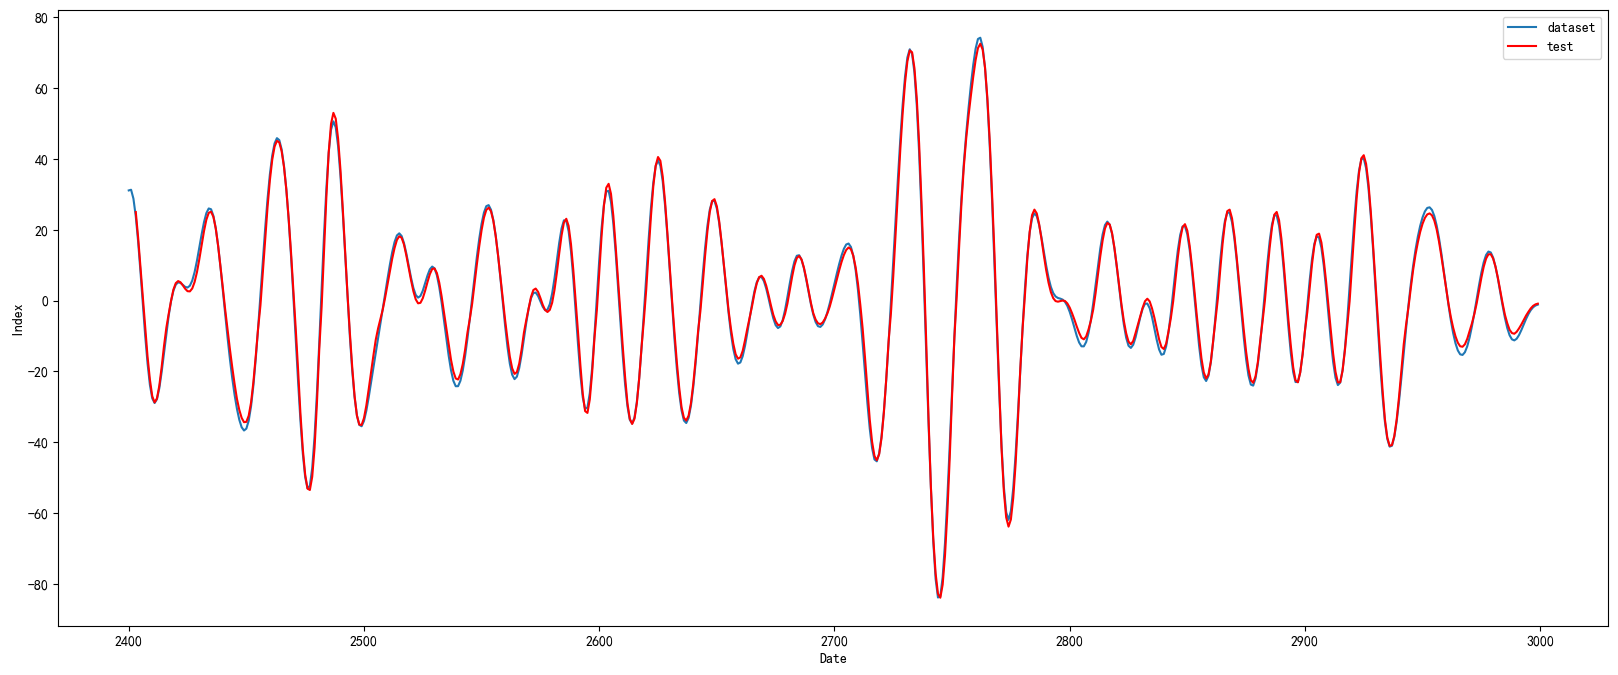

In [4]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,4])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF4_pre= pd.DataFrame(testPredict)
IMF4_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF5

<Figure size 2000x800 with 0 Axes>

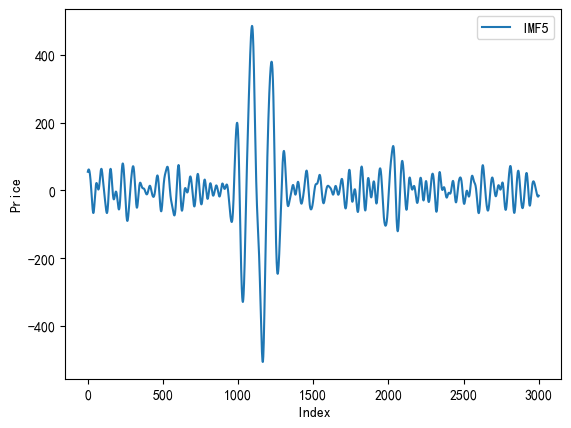

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_3 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 activation_3 (Activation)   (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 8.3432e-04 - mae: 0.0184 - val_loss: 5.5458e-05 - val_mae: 0.0061
Epoch 51/200
68/68 [==============================] - 1s 10ms/step - loss: 7.8755e-04 - mae: 0.0185 - val_loss: 5.7116e-05 - val_mae: 0.0060
Epoch 52/200
68/68 [==============================] - 1s 10ms/step - loss: 7.3246e-04 - mae: 0.0178 - val_loss: 1.0197e-04 - val_mae: 0.0082
Epoch 53/200
68/68 [==============================] - 1s 10ms/step - loss: 8.9269e-04 - mae: 0.0196 - val_loss: 2.0083e-04 - val_mae: 0.0118
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 6.7900e-04 - mae: 0.0174 - val_loss: 5.7948e-05 - val_mae: 0.0064
Epoch 55/200
68/68 [==============================] - 1s 10ms/step - loss: 6.7201e-04 - mae: 0.0162 - val_loss: 5.6181e-05 - val_mae: 0.0060
Epoch 56/200
68/68 [==============================] - 1s 10ms/step - loss: 6.6080e-04 - mae: 0.0170 - val_loss: 4.7332e-05 - val_mae: 0.0055
Epoch 57/200
68/68 [======

68/68 [==============================] - 1s 10ms/step - loss: 4.9754e-04 - mae: 0.0131 - val_loss: 2.9561e-05 - val_mae: 0.0045
Epoch 109/200
68/68 [==============================] - 1s 10ms/step - loss: 5.4923e-04 - mae: 0.0142 - val_loss: 3.1087e-05 - val_mae: 0.0046
Epoch 110/200
68/68 [==============================] - 1s 10ms/step - loss: 5.5134e-04 - mae: 0.0144 - val_loss: 1.3346e-04 - val_mae: 0.0102
Epoch 111/200
68/68 [==============================] - 1s 10ms/step - loss: 5.2233e-04 - mae: 0.0136 - val_loss: 4.7175e-05 - val_mae: 0.0055
Epoch 112/200
68/68 [==============================] - 1s 11ms/step - loss: 5.0663e-04 - mae: 0.0134 - val_loss: 3.8775e-05 - val_mae: 0.0050
Epoch 113/200
68/68 [==============================] - 1s 10ms/step - loss: 5.3223e-04 - mae: 0.0139 - val_loss: 2.9052e-05 - val_mae: 0.0044
Epoch 114/200
68/68 [==============================] - 1s 10ms/step - loss: 5.6129e-04 - mae: 0.0144 - val_loss: 5.7956e-05 - val_mae: 0.0061
Epoch 115/200
68/68 

Epoch 166/200
68/68 [==============================] - 1s 10ms/step - loss: 5.0964e-04 - mae: 0.0150 - val_loss: 2.9922e-05 - val_mae: 0.0046
Epoch 167/200
68/68 [==============================] - 1s 10ms/step - loss: 3.2849e-04 - mae: 0.0109 - val_loss: 7.7602e-05 - val_mae: 0.0074
Epoch 168/200
68/68 [==============================] - 1s 10ms/step - loss: 4.3651e-04 - mae: 0.0120 - val_loss: 1.8848e-05 - val_mae: 0.0036
Epoch 169/200
68/68 [==============================] - 1s 10ms/step - loss: 3.7403e-04 - mae: 0.0118 - val_loss: 8.6836e-05 - val_mae: 0.0082
Epoch 170/200
68/68 [==============================] - 1s 10ms/step - loss: 3.6550e-04 - mae: 0.0115 - val_loss: 4.5547e-05 - val_mae: 0.0057
Epoch 171/200
68/68 [==============================] - 1s 11ms/step - loss: 3.3934e-04 - mae: 0.0112 - val_loss: 5.8813e-05 - val_mae: 0.0062
Epoch 172/200
68/68 [==============================] - 1s 10ms/step - loss: 4.2951e-04 - mae: 0.0123 - val_loss: 2.6101e-05 - val_mae: 0.0042
Epoch 

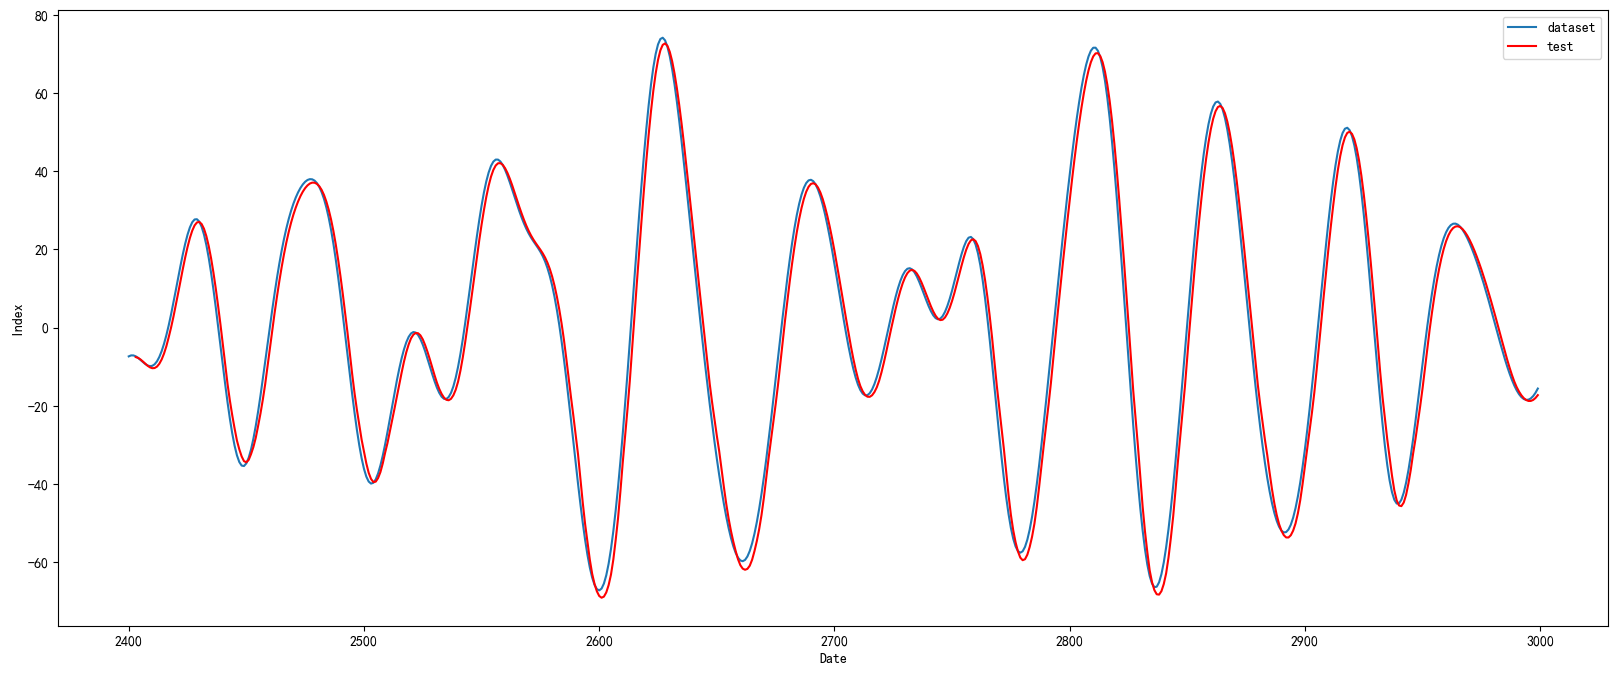

In [5]:
seed_value = 8
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,5])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF5_pre= pd.DataFrame(testPredict)
IMF5_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF6

<Figure size 2000x800 with 0 Axes>

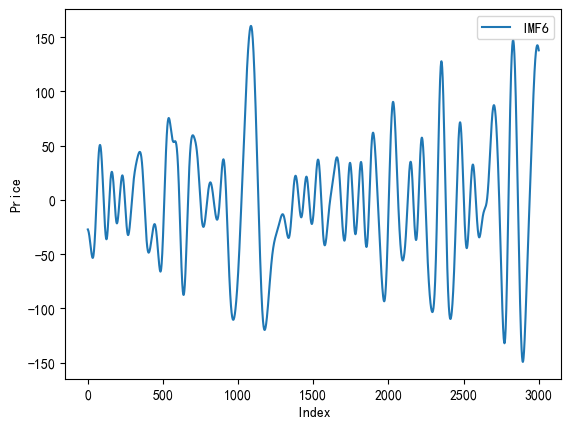

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_4 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 4.6038e-04 - val_mae: 0.0184
Epoch 52/200
68/68 [==============================] - 1s 11ms/step - loss: 9.5527e-04 - mae: 0.0219 - val_loss: 6.5189e-04 - val_mae: 0.0224
Epoch 53/200
68/68 [==============================] - 1s 11ms/step - loss: 0.0011 - mae: 0.0236 - val_loss: 6.5792e-04 - val_mae: 0.0226
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 5.4568e-04 - val_mae: 0.0208
Epoch 55/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0011 - mae: 0.0228 - val_loss: 5.3498e-04 - val_mae: 0.0193
Epoch 56/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0010 - mae: 0.0230 - val_loss: 5.5570e-04 - val_mae: 0.0210
Epoch 57/200
68/68 [==============================] - 1s 10ms/step - loss: 0.0010 - mae: 0.0228 - val_loss: 6.4932e-04 - val_mae: 0.0222
Epoch 58/200
68/68 [==============================

68/68 [==============================] - 1s 10ms/step - loss: 6.7802e-04 - mae: 0.0184 - val_loss: 2.9972e-04 - val_mae: 0.0145
Epoch 110/200
68/68 [==============================] - 1s 10ms/step - loss: 7.2806e-04 - mae: 0.0192 - val_loss: 3.9192e-04 - val_mae: 0.0174
Epoch 111/200
68/68 [==============================] - 1s 10ms/step - loss: 6.4910e-04 - mae: 0.0182 - val_loss: 3.7280e-04 - val_mae: 0.0156
Epoch 112/200
68/68 [==============================] - 1s 10ms/step - loss: 6.5114e-04 - mae: 0.0183 - val_loss: 4.5017e-04 - val_mae: 0.0183
Epoch 113/200
68/68 [==============================] - 1s 10ms/step - loss: 7.2543e-04 - mae: 0.0188 - val_loss: 5.4614e-04 - val_mae: 0.0206
Epoch 114/200
68/68 [==============================] - 1s 10ms/step - loss: 6.2299e-04 - mae: 0.0179 - val_loss: 3.1241e-04 - val_mae: 0.0150
Epoch 115/200
68/68 [==============================] - 1s 10ms/step - loss: 6.8704e-04 - mae: 0.0188 - val_loss: 4.9723e-04 - val_mae: 0.0191
Epoch 116/200
68/68 

Epoch 167/200
68/68 [==============================] - 1s 10ms/step - loss: 5.8571e-04 - mae: 0.0169 - val_loss: 4.9569e-04 - val_mae: 0.0195
Epoch 168/200
68/68 [==============================] - 1s 10ms/step - loss: 6.0404e-04 - mae: 0.0173 - val_loss: 4.0587e-04 - val_mae: 0.0173
Epoch 169/200
68/68 [==============================] - 1s 10ms/step - loss: 5.7233e-04 - mae: 0.0169 - val_loss: 4.2842e-04 - val_mae: 0.0181
Epoch 170/200
68/68 [==============================] - 1s 10ms/step - loss: 5.4963e-04 - mae: 0.0164 - val_loss: 3.3453e-04 - val_mae: 0.0159
Epoch 171/200
68/68 [==============================] - 1s 10ms/step - loss: 5.8584e-04 - mae: 0.0170 - val_loss: 4.9865e-04 - val_mae: 0.0196
Epoch 172/200
68/68 [==============================] - 1s 10ms/step - loss: 5.5513e-04 - mae: 0.0164 - val_loss: 2.9355e-04 - val_mae: 0.0146
Epoch 173/200
68/68 [==============================] - 1s 10ms/step - loss: 5.7997e-04 - mae: 0.0169 - val_loss: 2.2614e-04 - val_mae: 0.0124
Epoch 

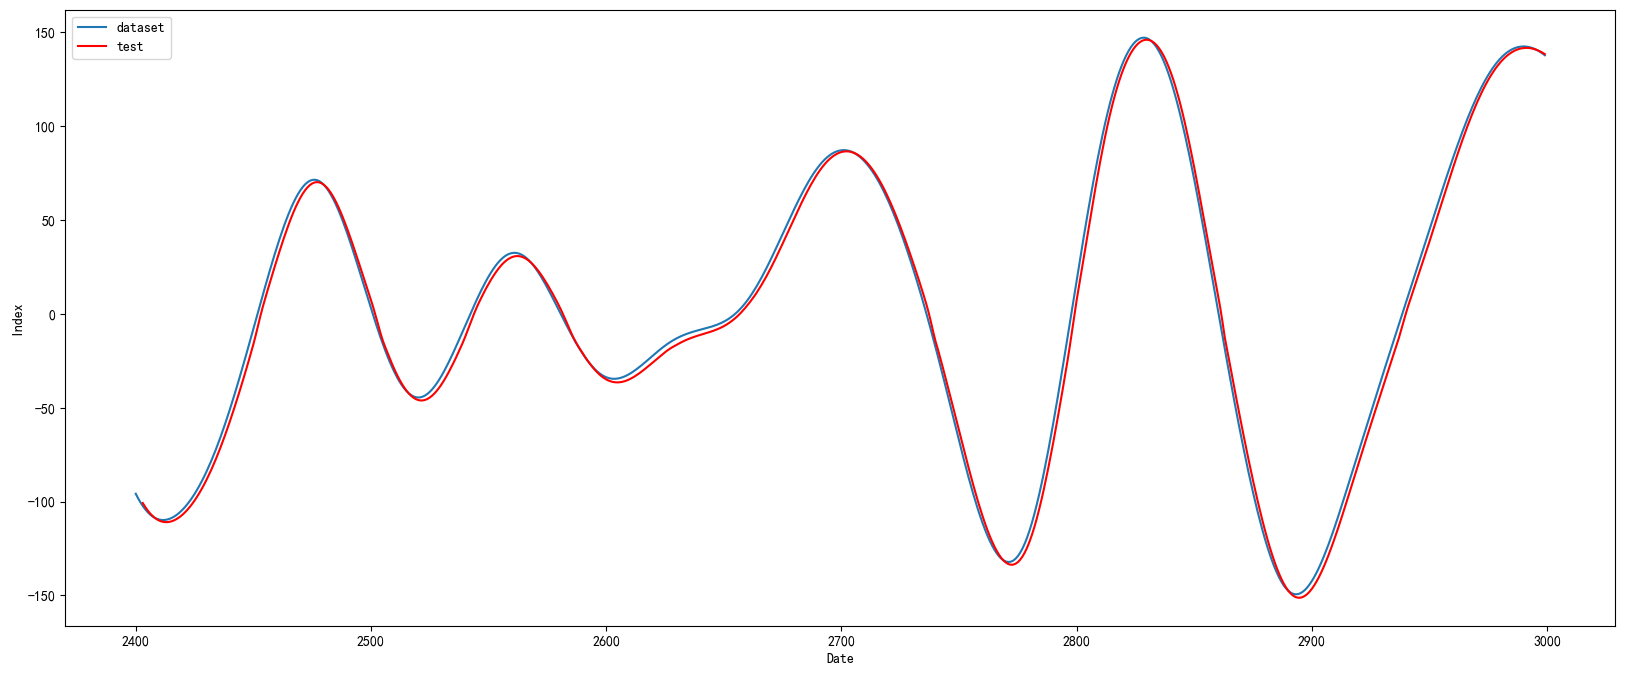

In [6]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,6])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF6_pre= pd.DataFrame(testPredict)
IMF6_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF7

<Figure size 2000x800 with 0 Axes>

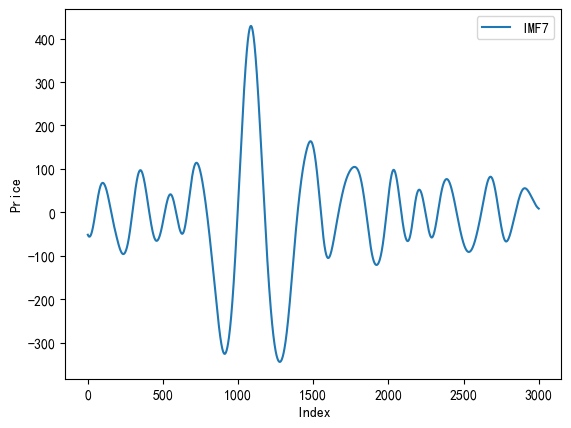

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_5 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 activation_5 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

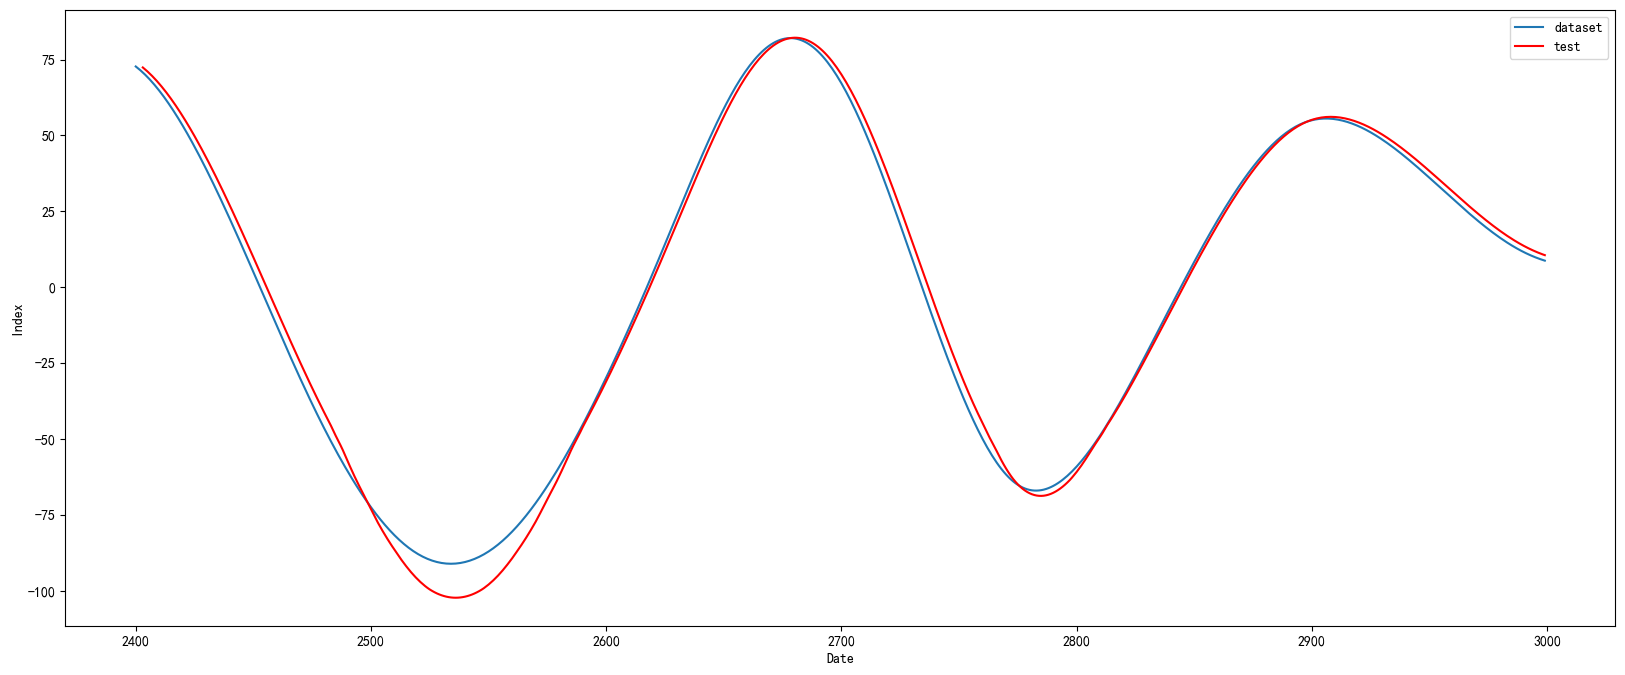

In [7]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,7])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF7_pre= pd.DataFrame(testPredict)
IMF7_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF8

<Figure size 2000x800 with 0 Axes>

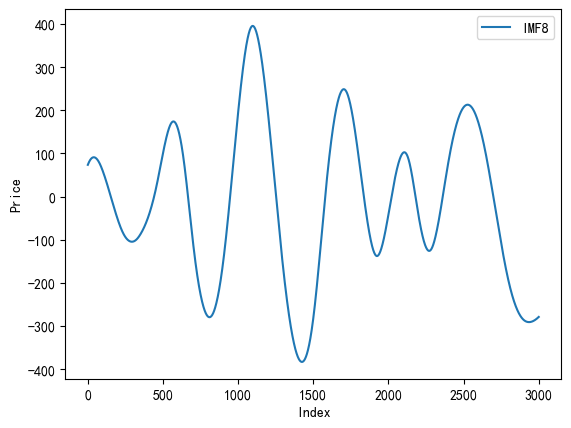

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_6 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

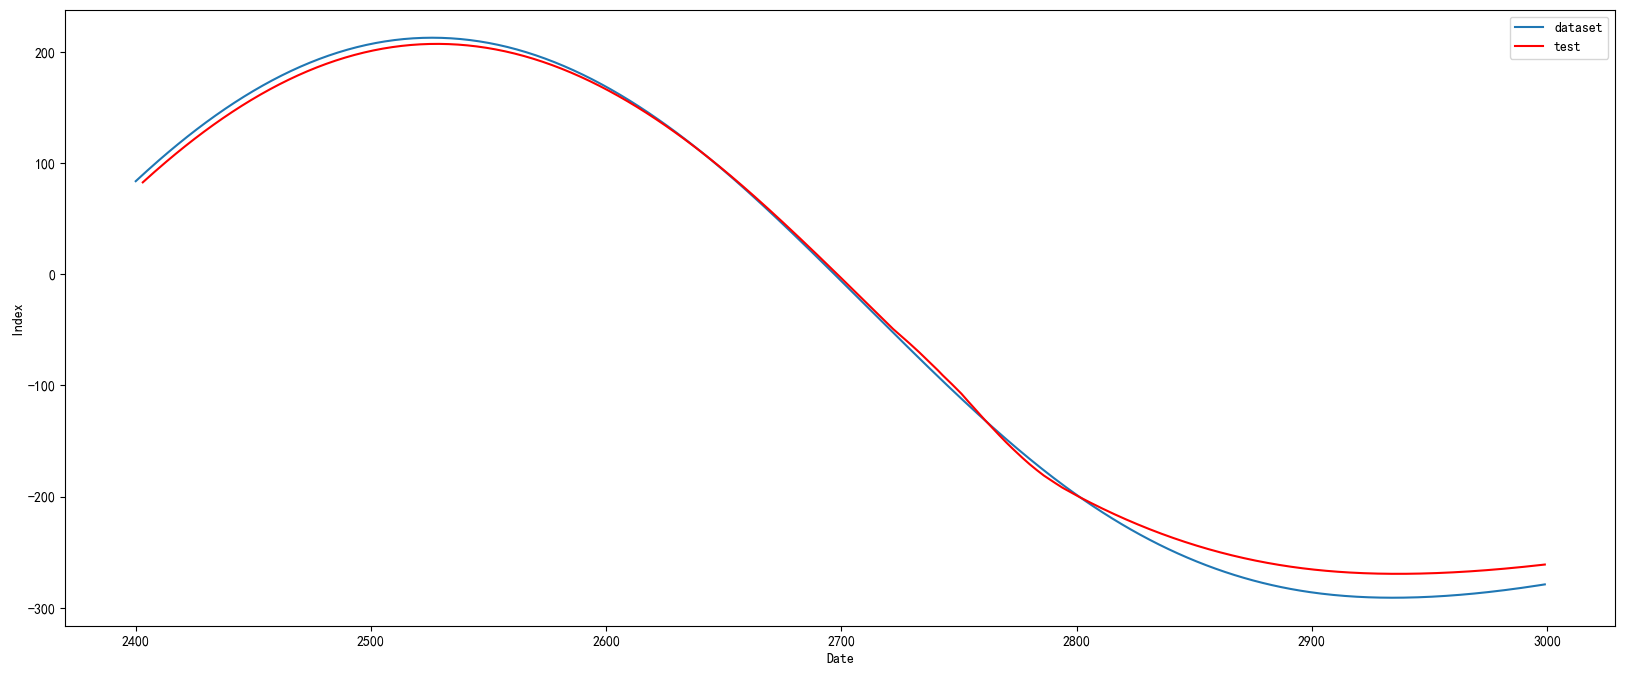

In [8]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,8])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF8_pre= pd.DataFrame(testPredict)
IMF8_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF9

<Figure size 2000x800 with 0 Axes>

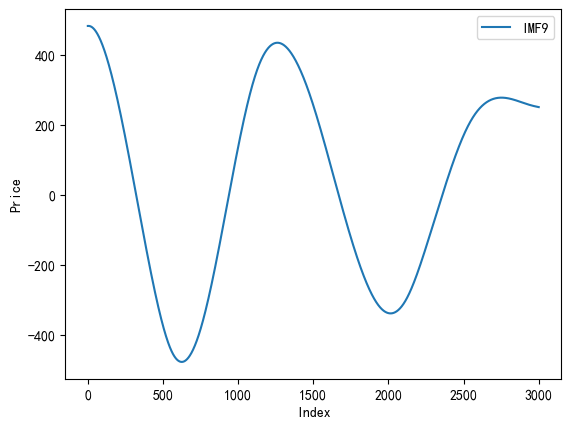

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_7 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 0.0029 - mae: 0.0398 - val_loss: 1.7845e-04 - val_mae: 0.0104
Epoch 52/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0399 - val_loss: 2.2955e-04 - val_mae: 0.0131
Epoch 53/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0398 - val_loss: 4.0299e-04 - val_mae: 0.0185
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0031 - mae: 0.0412 - val_loss: 6.4219e-05 - val_mae: 0.0071
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0030 - mae: 0.0406 - val_loss: 4.7418e-04 - val_mae: 0.0194
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0394 - val_loss: 4.3492e-05 - val_mae: 0.0063
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 2.2239e-04 - val_mae: 0.0113
Epoch 58/100
68/68 [==============================] - 1s 9ms

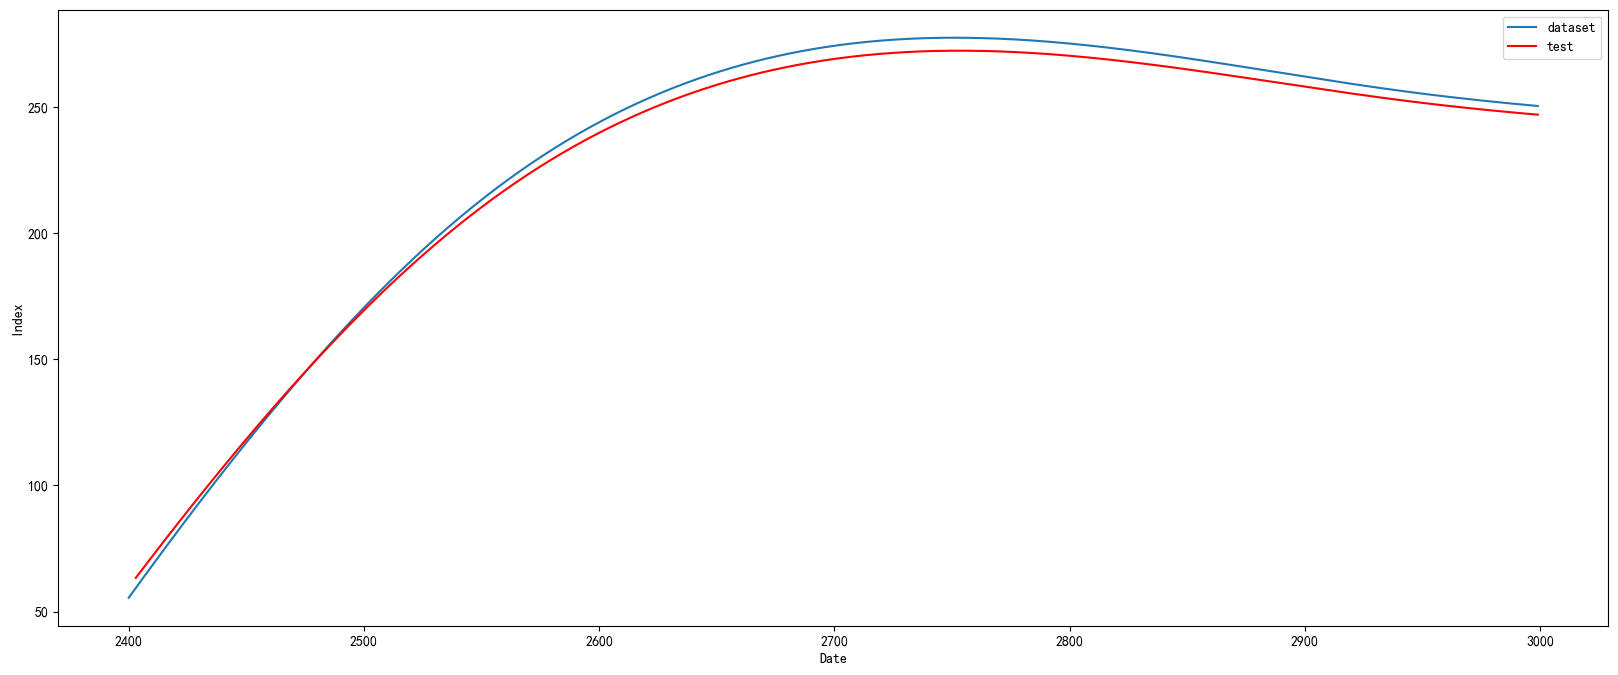

In [9]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,9])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF9_pre= pd.DataFrame(testPredict)
IMF9_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Res

<Figure size 2000x800 with 0 Axes>

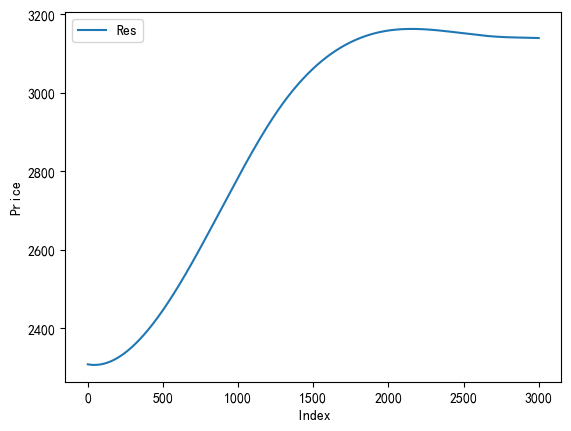

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_8 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 activation_8 (Activation)   (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

Epoch 52/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0076 - mae: 0.0643 - val_loss: 6.6070e-07 - val_mae: 8.0549e-04
Epoch 53/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0071 - mae: 0.0623 - val_loss: 1.7308e-07 - val_mae: 4.0502e-04
Epoch 54/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0075 - mae: 0.0640 - val_loss: 0.0020 - val_mae: 0.0450
Epoch 55/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0072 - mae: 0.0623 - val_loss: 1.5603e-04 - val_mae: 0.0125
Epoch 56/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0068 - mae: 0.0613 - val_loss: 0.0016 - val_mae: 0.0395
Epoch 57/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0065 - mae: 0.0604 - val_loss: 9.5804e-05 - val_mae: 0.0098
Epoch 58/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0069 - mae: 0.0619 - val_loss: 5.8661e-04 - val_mae: 0.0242
Epoch 59/100
17/17 [=====================

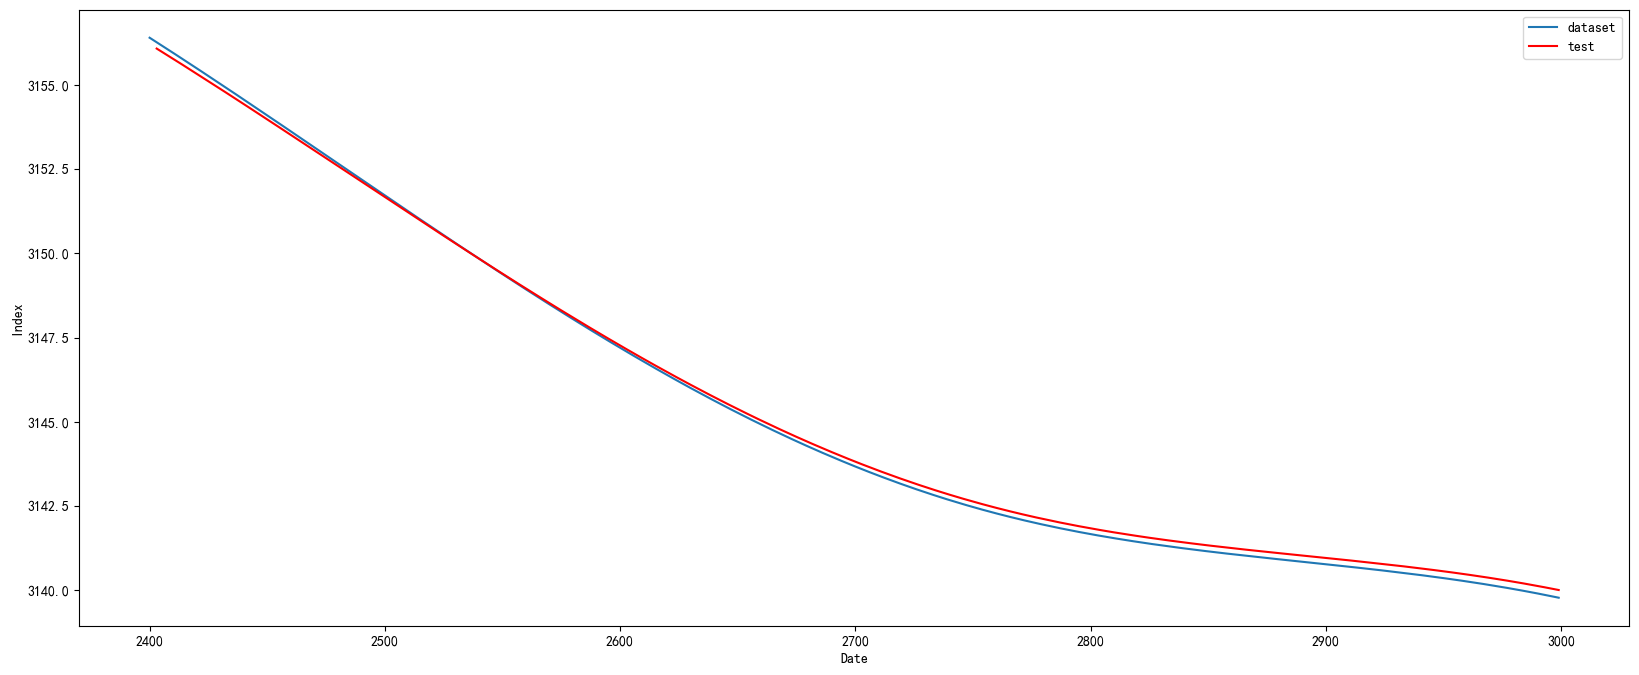

In [10]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN SSEC Low modes_data.csv', index_col=0,usecols=[0,10])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=128, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
Res_pre= pd.DataFrame(testPredict)
Res_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF1

<Figure size 2000x800 with 0 Axes>

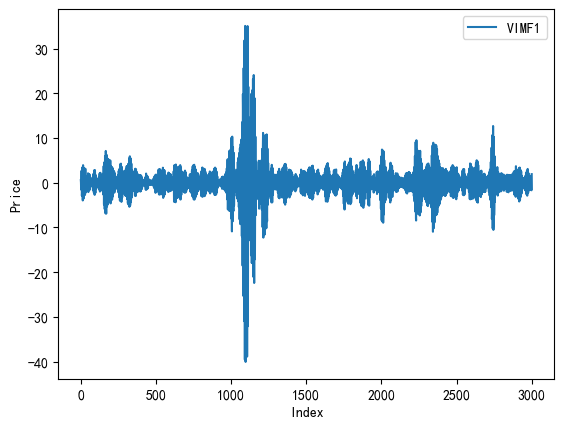

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_9 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 activation_9 (Activation)   (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

19/19 [==============================] - 1s 3ms/step
Test Sccore 8677.0754 MAPE
Test Score: 0.4610 MAE
Test Score: 0.5904 RMSE


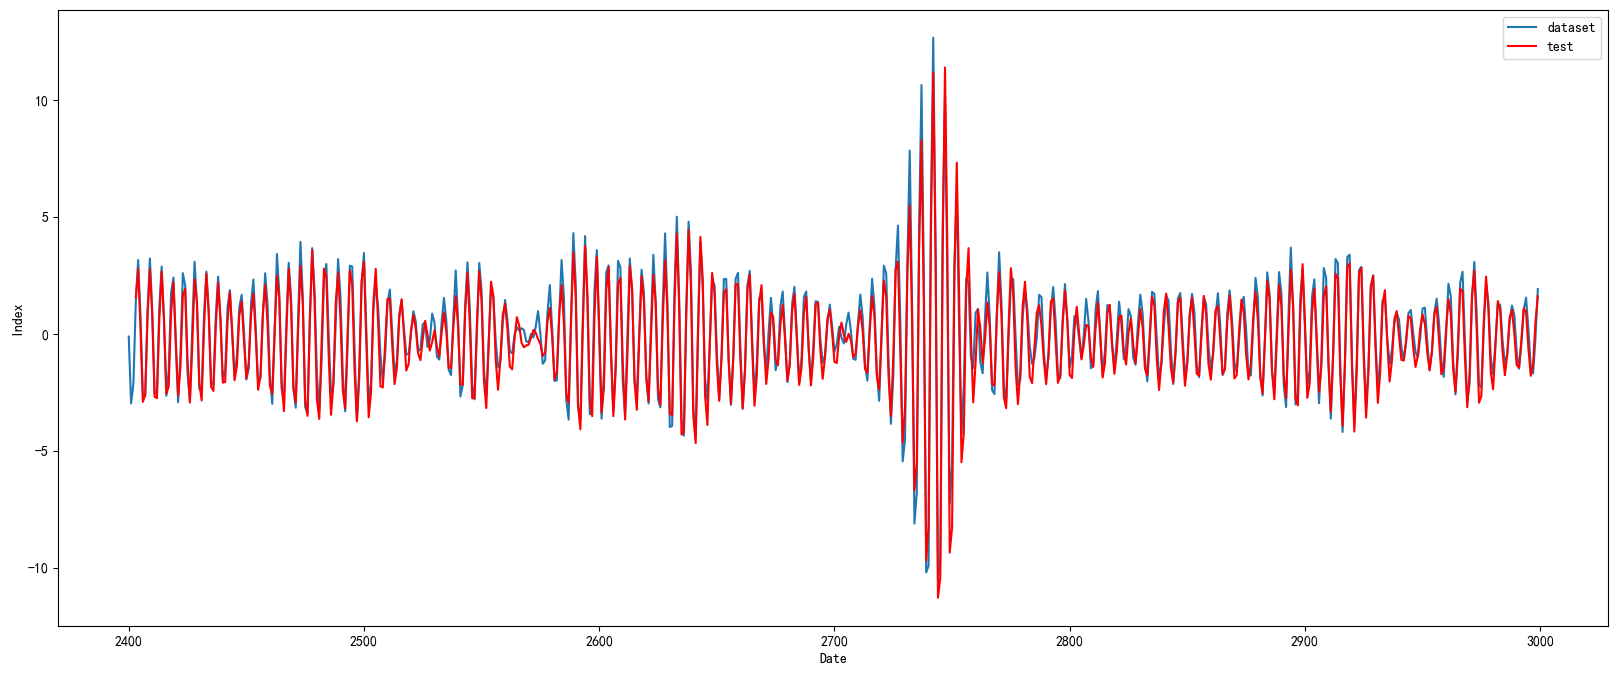

In [11]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./SSEC Low VIMFs.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF1_pre= pd.DataFrame(testPredict)
VIMF1_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF2

<Figure size 2000x800 with 0 Axes>

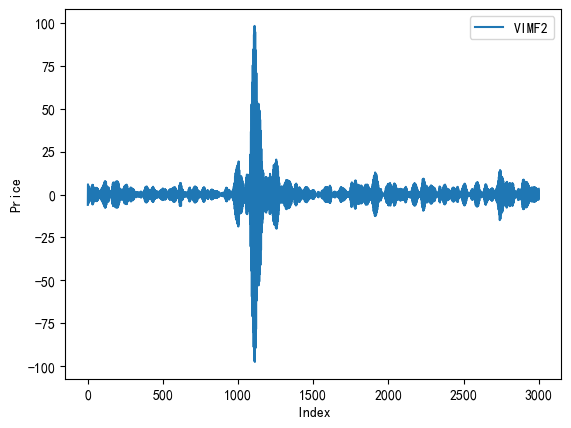

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_10 (TCN)                (None, 32)                26912     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

Epoch 51/100
68/68 [==============================] - 1s 8ms/step - loss: 6.5452e-04 - mae: 0.0160 - val_loss: 2.1990e-04 - val_mae: 0.0126
Epoch 52/100
68/68 [==============================] - 1s 9ms/step - loss: 4.5050e-04 - mae: 0.0128 - val_loss: 1.3159e-04 - val_mae: 0.0093
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 4.4161e-04 - mae: 0.0122 - val_loss: 6.8682e-05 - val_mae: 0.0063
Epoch 53: early stopping
75/75 [==============================] - 0s 3ms/step - loss: 7.8857e-05 - mae: 0.0046
7.885738887125626e-05 0.004571369383484125
19/19 [==============================] - 1s 2ms/step
Test Sccore 73.2264 MAPE
Test Score: 0.6542 MAE
Test Score: 0.8658 RMSE


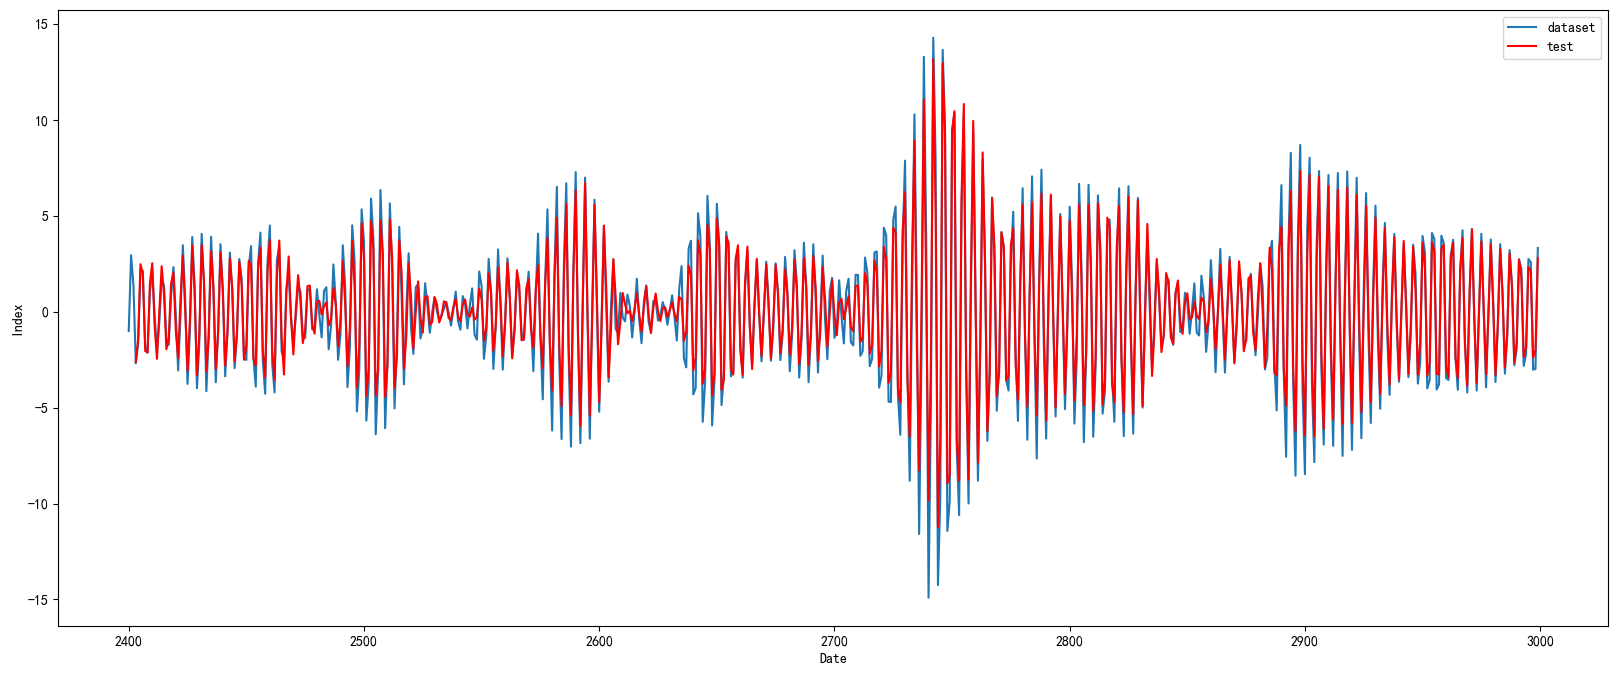

In [12]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./SSEC Low VIMFs.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF2_pre= pd.DataFrame(testPredict)
VIMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF3

<Figure size 2000x800 with 0 Axes>

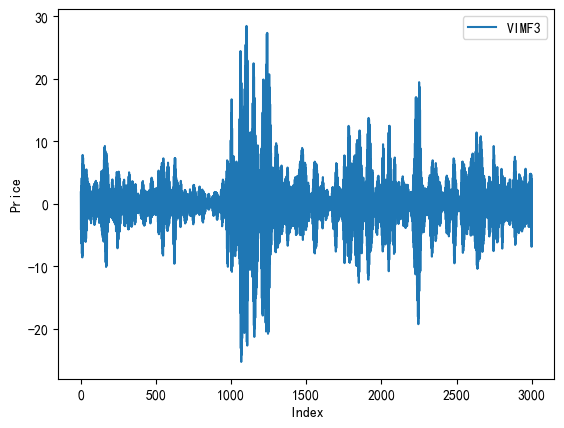

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_11 (TCN)                (None, 32)                26912     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 activation_11 (Activation)  (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

68/68 [==============================] - 1s 9ms/step - loss: 9.6165e-04 - mae: 0.0220 - val_loss: 5.3622e-04 - val_mae: 0.0198
Epoch 52/100
68/68 [==============================] - 1s 9ms/step - loss: 8.8124e-04 - mae: 0.0204 - val_loss: 3.3583e-04 - val_mae: 0.0142
Epoch 53/100
68/68 [==============================] - 1s 9ms/step - loss: 8.3533e-04 - mae: 0.0208 - val_loss: 2.1218e-04 - val_mae: 0.0107
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 8.7737e-04 - mae: 0.0208 - val_loss: 6.2080e-04 - val_mae: 0.0204
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 8.1398e-04 - mae: 0.0198 - val_loss: 8.5295e-04 - val_mae: 0.0255
Epoch 56/100
68/68 [==============================] - 1s 8ms/step - loss: 9.0048e-04 - mae: 0.0212 - val_loss: 5.1274e-04 - val_mae: 0.0174
Epoch 57/100
68/68 [==============================] - 1s 8ms/step - loss: 8.6601e-04 - mae: 0.0211 - val_loss: 2.0362e-04 - val_mae: 0.0109
Epoch 58/100
68/68 [=============

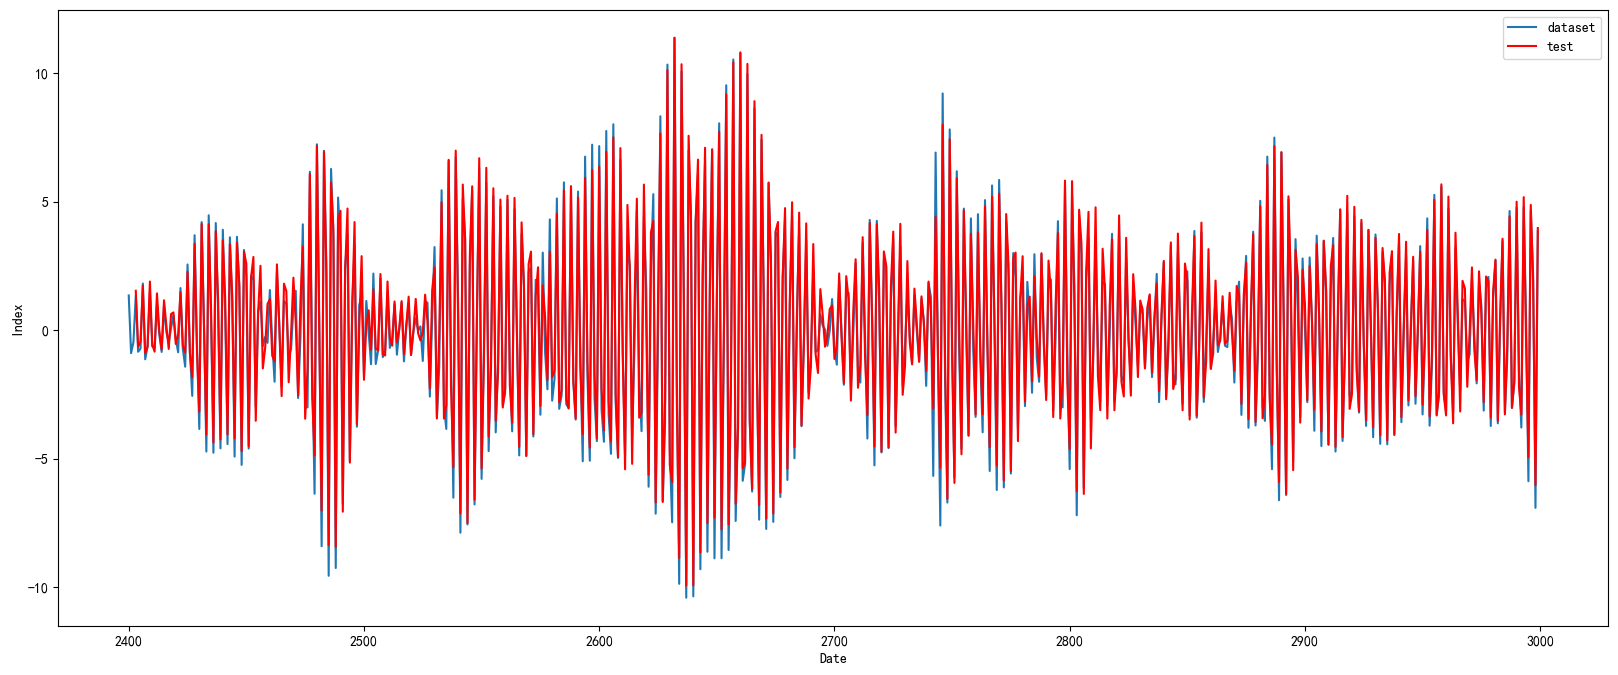

In [13]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./SSEC Low VIMFs.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF3_pre= pd.DataFrame(testPredict)
VIMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Original

<Figure size 2000x800 with 0 Axes>

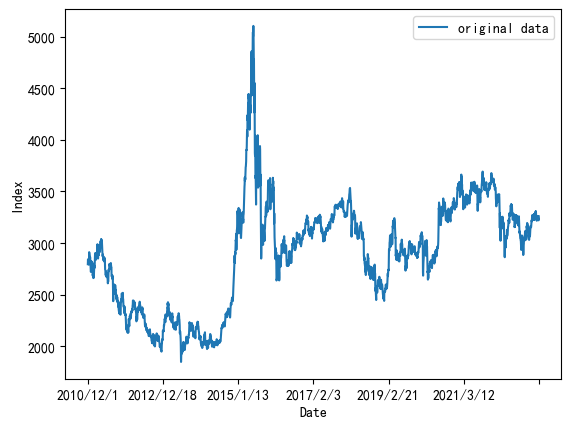

In [14]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
dataframe = read_csv('./SSEC Index Low.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.yticks()
plt.legend(['original data'])
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :] 


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


testY = scaler.inverse_transform([testY]) 

Original_pre= pd.DataFrame(testPredict)
Original_true= pd.DataFrame(testY[0])

In [15]:
testPredict=pd.concat([IMF2_pre,
                       IMF3_pre,
                       IMF4_pre,
                       IMF5_pre,
                       IMF6_pre,
                       IMF7_pre,
                       IMF8_pre,
                       IMF9_pre,
                       Res_pre,
                       VIMF1_pre,
                       VIMF2_pre,
                       VIMF3_pre,],axis=1)  


testPredict["pre_sum"]=testPredict.sum(axis=1)

testPredict["Original_true"]=Original_true

In [16]:
testScore_2= mape(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testPredict["Original_true"], testPredict["pre_sum"]))
print('Test Score: %.4f RMSE' % (testScore))

Test Sccore 0.4326 MAPE
Test Score: 14.3112 MAE
Test Score: 17.7202 RMSE


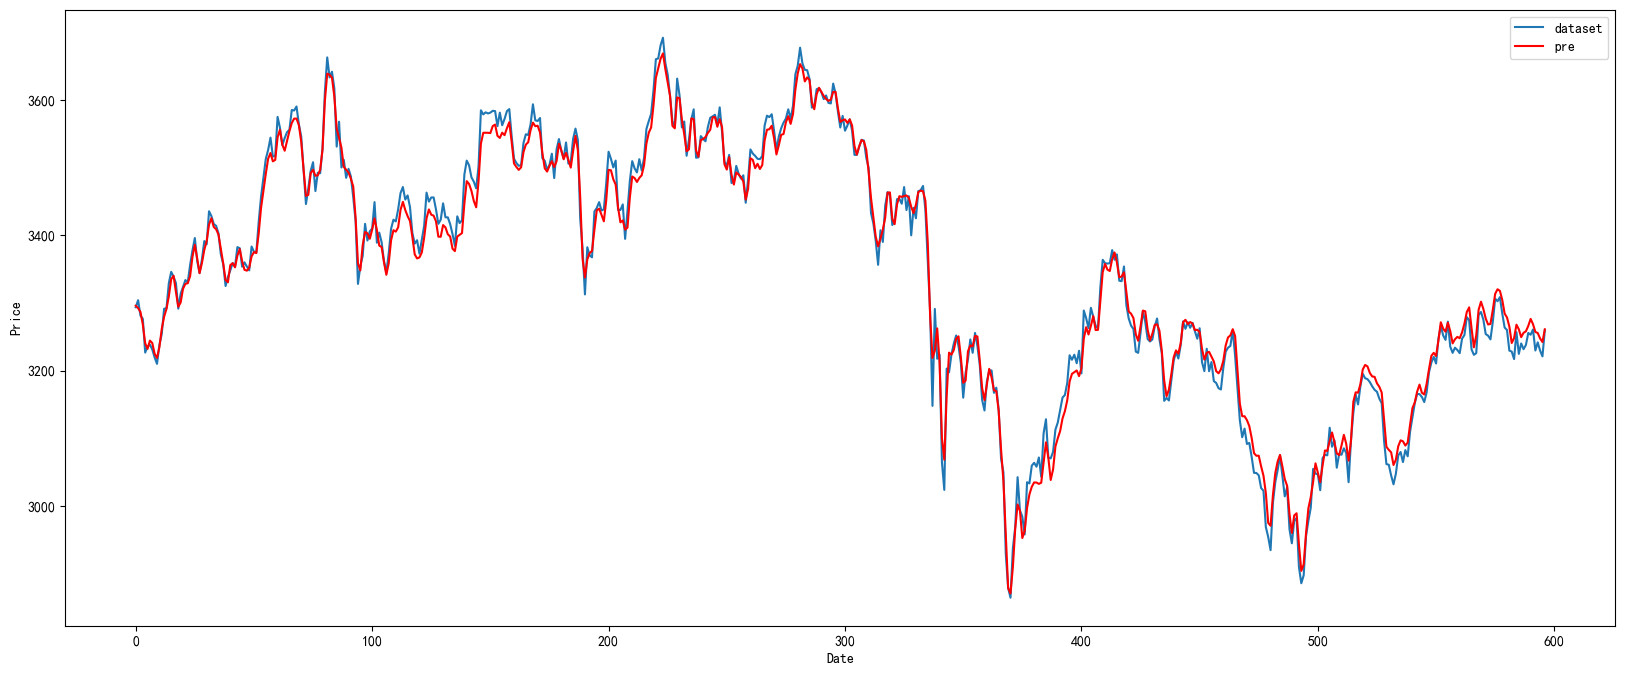

In [17]:
plt.figure(figsize=(20,8))
plt.plot(testPredict["Original_true"], label='dataset')
plt.plot(testPredict["pre_sum"],color='r', label='pre')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [18]:
# 最终集成并写入csv
Finally_excel=testPredict

Finally_excel.to_csv('./Finally_excel.csv')

In [19]:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Execution time: 847.61 seconds
